# SAM for graphene TEM images

## 🧩 Introduction

This notebook explores the use of the **Segment Anything Model (SAM)** for the segmentation of graphene flakes in transmission and scanning electron microscopy (TEM/SEM) images.  

- **Segment Anything Model (SAM)**  
  SAM is a state-of-the-art segmentation framework developed by Meta AI.  
  - It was trained on over 1 billion masks across 11 million images.  
  - Its key strength is the ability to perform **prompt-based segmentation**, where users provide clicks, bounding boxes, or textual hints, and the model generates segmentation masks without additional training.  
  - SAM generalizes across diverse image domains, making it a promising tool for scientific image analysis.  

- **Graphene flake images**  
  TEM and SEM images of graphene present unique challenges for segmentation:  
  - **Heterogeneous morphology**: flakes vary in size, shape, and thickness.  
  - **Irregular boundaries**: edges are rough and often overlap with neighboring flakes.  
  - **Carbon support holes**: present in most images, introducing additional edges and contrast artifacts.  
  - **Overlapping structures**: flakes and holes may intersect, complicating boundary definition.  

The goal of this experiment is to test whether SAM can be applied effectively to graphene images:  
1. To accelerate the annotation process by generating candidate masks automatically.  
2. To reduce manual effort in creating pixel-level labels.  
3. To evaluate if SAM’s general-purpose capabilities transfer to the domain of **graphene material characterization**.  

This forms part of the **ACCORDS project**, where deep learning methods are developed for automated analysis of carbon-based nanomaterials.


## 🔧 Step 1: Google Drive Setup

This step ensures a clean mount of **Google Drive** in the Colab environment.  
To avoid conflicts with previously mounted sessions:  

1. **Unmount** Google Drive if it was already connected.  
2. **Clear the mount point** (`/content/drive`) by removing any leftover files or directories.  
3. **Remount** Google Drive to provide access to project files (datasets, models, outputs).  

This procedure guarantees a consistent and reproducible environment each time the notebook is run, preventing issues with stale or conflicting files.


In [2]:
# Unmount Google Drive if already mounted
try:
    from google.colab import drive
    drive.flush_and_unmount()
    print('Google Drive unmounted successfully.')
except ValueError:
    print('Google Drive not mounted.')
except Exception as e:
    print(f'An error occurred during unmounting: {e}')

# Ensure the mount point is empty before mounting
import os
import shutil

mountpoint = '/content/drive'
if os.path.exists(mountpoint) and os.path.isdir(mountpoint):
    if os.listdir(mountpoint):
        print(f'Mount point {mountpoint} is not empty. Attempting to remove contents.')
        try:
            for item in os.listdir(mountpoint):
                item_path = os.path.join(mountpoint, item)
                if os.path.isfile(item_path):
                    os.remove(item_path)
                elif os.path.isdir(item_path):
                    shutil.rmtree(item_path)
            print('Mount point contents removed successfully.')
        except Exception as e:
            print(f'Error removing mount point contents: {e}')
    else:
        print(f'Mount point {mountpoint} is empty.')
else:
    print(f'Mount point {mountpoint} does not exist or is not a directory.')


# Now mount Google Drive
from google.colab import drive
drive.mount(mountpoint)

Google Drive unmounted successfully.
Mount point /content/drive does not exist or is not a directory.
Mounted at /content/drive


In [3]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python matplotlib

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-6k8dhlko
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-6k8dhlko
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [4]:
# 4. Import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator


In [5]:
# 5. Define paths
image_dir = '/content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/notebooks/deeplearning/SAM/images'
output_dir = '/content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/notebooks/deeplearning/SAM/outputs'
os.makedirs(output_dir, exist_ok=True)

# Checkpointa
checkpoint_path = "/content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/notebooks/deeplearning/SAM/content/sam_vit_h_4b8939.pth"
#checkpoint_path = "./sam_vit_h_4b8939.pth"

In [6]:
# 6. Load SAM2 model (vit_h)
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry["vit_h"](checkpoint=checkpoint_path)
sam.to(device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

## 🖼️ Step 2: Initialize SAM Mask Generator

At this stage, the **Segment Anything Model (SAM)** is configured to automatically generate segmentation masks.  
The class `SamAutomaticMaskGenerator` creates a wrapper around the pretrained SAM model, enabling it to propose multiple candidate masks for a given image without requiring manual prompts.

- **Input**: a raw microscopy image.  
- **Output**: a set of candidate segmentation masks, each with metadata such as area, bounding box, and confidence score.  

This approach allows fast exploration of how SAM interprets graphene TEM/SEM images and serves as the starting point for subsequent refinement or manual correction.


In [7]:
# Mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

## 🧪 Step 3: Apply SAM to a Graphene Image

In this step, the **Segment Anything Model (SAM)** is applied to a single TEM/SEM image of graphene:

1. **Load the image** from the dataset (`.tiff` format).  
   - If the file cannot be read, an error message is returned.  
2. **Preprocess** the image by converting it from OpenCV’s default BGR format to RGB, which is required by SAM.  
3. **Generate candidate masks** using the previously initialized `mask_generator`.  
   - Each mask includes binary segmentation, area, bounding box, and confidence metadata.  
4. **Visualize the results** by overlaying red contours on the original image.  
   - The plot also displays the total number of masks detected.

This provides an initial qualitative evaluation of SAM’s ability to detect graphene flakes and carbon support holes.  
The goal is to assess whether the automatically proposed masks correspond to meaningful structures in the microscopy images.


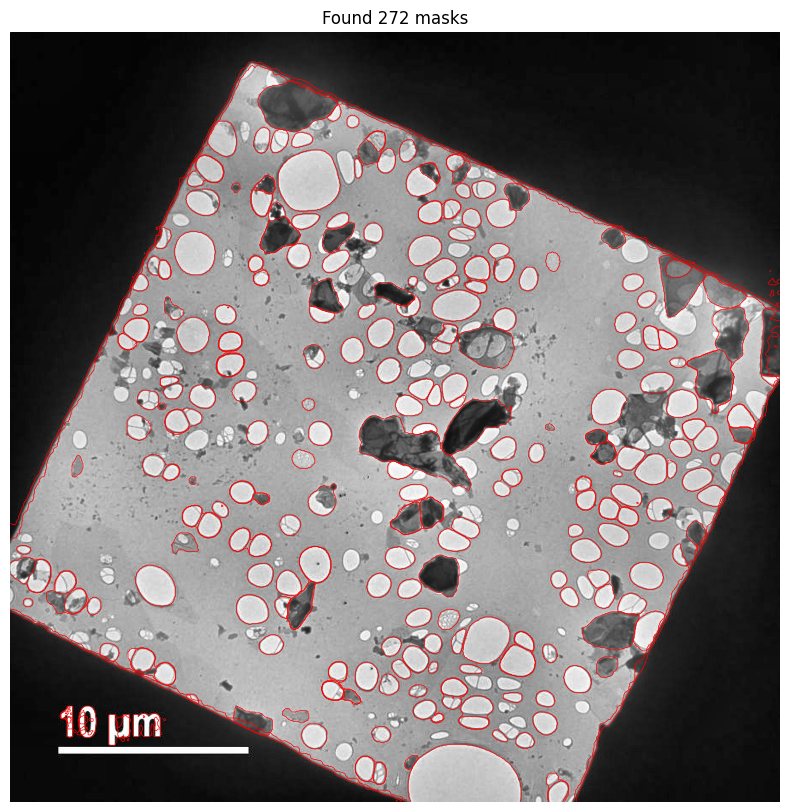

In [8]:
# 7. Apply SAM to one image
image_path = os.path.join(image_dir, '1AC_UT_GO_02_01_2000X_0002.tiff')  # Change to your actual image
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print(f"Error: Could not load image from {image_path}")
else:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    masks = mask_generator.generate(image_rgb)

    # Visualize result
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    for mask in masks:
        plt.contour(mask['segmentation'], colors='r', linewidths=0.5)
    plt.axis('off')
    plt.title(f"Found {len(masks)} masks")
    plt.show()

In [ ]:
# 🎨 Alternative visualization: random-colored masks overlay
import numpy as np

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)

# Generate a random color for each mask and overlay it with transparency
for mask in masks:
    color = np.random.rand(3)  # random RGB color
    segmentation = mask['segmentation']
    plt.imshow(
        np.dstack([segmentation * color[i] for i in range(3)]),
        alpha=0.35  # transparency for blending with the image
    )

plt.axis('off')
plt.title(f"Found {len(masks)} masks (colored overlay)")
plt.show()


In [ ]:
# 🔎 Holes vs. Graphene classification with k-NN
import numpy as np
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage import measure
from scipy.ndimage import binary_dilation
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

# --- Feature extractor ---
def extract_features(image_gray, mask_bool):
    m = mask_bool.astype(bool)
    vals = image_gray[m]
    if vals.size == 0:
        return np.zeros(6)  # empty fallback

    mean_int = vals.mean()
    std_int = vals.std()

    # shape descriptors
    area = m.sum()
    perim = measure.perimeter(m)
    circularity = 4 * np.pi * area / (perim**2 + 1e-6)

    # texture
    ent = entropy((image_gray * 255).astype(np.uint8), disk(3))[m].mean()

    # border contrast
    ring = binary_dilation(m, iterations=2) & ~m
    ring_vals = image_gray[ring]
    border_contrast = (mean_int - ring_vals.mean()) if ring_vals.size else 0.0

    return np.array([mean_int, std_int, ent, area, circularity, border_contrast])

# --- Build feature matrix ---
image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY) / 255.0
X = np.vstack([extract_features(image_gray, mask['segmentation']) for mask in masks])

# --- Example manual seed labels ---
# 👉 tutaj musisz ręcznie oznaczyć kilkanaście masek (np. na podstawie wizualizacji):
# 0 = graphene, 1 = hole
# np. idx_labeled = [0, 5, 12, 23]; y_labeled = [0, 1, 0, 1]
idx_labeled = []   # fill with indices of labeled masks
y_labeled   = []   # fill with your labels

# --- Train k-NN if labels are provided ---
if len(idx_labeled) > 0:
    clf = make_pipeline(StandardScaler(),
                        KNeighborsClassifier(n_neighbors=9, weights='distance'))
    clf.fit(X[idx_labeled], y_labeled)

    # predict on all objects
    proba = clf.predict_proba(X)[:, 1]  # p(hole)
    pred  = (proba >= 0.6).astype(int)

    # attach results back to masks
    for i, mask in enumerate(masks):
        mask['class_pred'] = 'hole' if pred[i] == 1 else 'graphene'
        mask['p_hole'] = proba[i]

    # summary
    print("Classification complete!")
    print(f"Predicted holes: {sum(pred)}, graphene: {len(pred)-sum(pred)}")
else:
    print("⚠️ Please provide manual seed labels in idx_labeled and y_labeled.")

